<a href="https://colab.research.google.com/github/MichaelGindin/MS-segmentation-model/blob/main/MS_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from io import FileIO
from PIL import Image 
import sys, os
import pathlib
import cv2 
import glob
from skimage.io import imread_collection
from nibabel.testing import data_path
import nibabel as nib
import pylab as plt
from keras.models import Model
from keras.layers import Input, Add, PReLU, Conv2DTranspose, Concatenate, MaxPooling2D, UpSampling2D, Dropout
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import Callback
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from google.colab.patches import cv2_imshow

## Access Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define parameters

In [ ]:
LearningRate = 0.00001 #  check: 0.00001
NUM_EPOCHS = 100        #  check: 50 100 
BATCH_SIZE = 32        #  check: 16 32
crop_size = 32         #  check: 32 64
crop_precentage = 0.2 #  check: 0.3 0.5 0.6 
Gamma=4.0

#chosing optimizer
ChosenOptimizer = Adam(learning_rate = LearningRate)
loss_function = tf.keras.losses.BinaryFocalCrossentropy(  gamma=Gamma, from_logits=False)
#loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=False) 
#loss_function= 'mse'
ModolalityType ='-T2'  #'-T1' #'-Flair' 

ModelDepth = 4

run_folder_output = "BinaryFocalCrossentropy"+ '-Ep'+str(NUM_EPOCHS)+'-B'+str(BATCH_SIZE)+'-CrSize'+str(crop_size)+'-CrPrecent'+str(crop_precentage)+'-LR'+str(LearningRate)+ModolalityType+'-Gamma'+str(Gamma)+'-Depth'+str(ModelDepth) #need to change each run time

#creating path of output
weights_path = '/content/drive/MyDrive/New_Final_Project_Weights/Modality/'+run_folder_output
Path(weights_path).mkdir(parents=True,exist_ok=True)
numberWeight = 95
filePath = 'weights.'+str(numberWeight)+'.hdf5'

# Access to DB

In [ ]:
#Loading Images from db
def upload_db_images(path, MRI_modality,couples):
    listImages = []
    listMasks = []
    listFilesImages = []
    listFilesMasks = []
    for r,d,f in os.walk(path):
        x = None
        y = None
        for files in f:
            if (MRI_modality+'.nii') in files :
                ex = os.path.join(r, files)
                if 'Seg' in files:
                  listFilesMasks.append(r)
                  listMasks.append( nib.load(ex))
                  y = nib.load(ex)
                  #print(ex)
                else:
                  listFilesImages.append(r)
                  listImages.append(nib.load(ex))
                  x = nib.load(ex)
                  #print(ex)
        if(x!=None and y!=None):
          couples.append([x,y])
    return listImages,listMasks,listFilesImages,listFilesMasks,couples

**Loading images**

In [ ]:
couples=[]

In [ ]:
listImages,listMasks,listFilesImages,listFilesMasks,couples = upload_db_images(r'/content/drive/MyDrive/DB_final_project/Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information',ModolalityType,couples)

In [ ]:
listImages2,listMasks2,listFilesImages2,listFilesMasks2,couples = upload_db_images(r'/content/drive/MyDrive/DB_final_project/DB-Train',ModolalityType,couples)

# Preproccessed the data part: crop and resize augmentation then normalize

In [ ]:
#crop black background
def crop_image(image, mask):
    image2 = image[:,:,image.shape[2]//2]
    max_cols = np.amax(image2,axis=0)
    nonzero_cols = np.nonzero(max_cols)
    first_col = nonzero_cols[0].min()
    last_col = nonzero_cols[0].max()
    max_rows = np.amax(image2, axis=1)
    nonzero_rows = np.nonzero(max_rows)
    first_row = nonzero_rows[0].min()
    last_row = nonzero_rows[0].max()
    image = image[first_row:last_row,first_col:last_col:,]
    mask = mask[first_row:last_row,first_col:last_col:,]
    return np.uint8(image),mask

In [1]:
#Resizing images to the same size
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (256, 256), method="nearest")
   input_mask = tf.image.resize(input_mask, (256, 256), method="nearest")
   return input_image, input_mask

In [ ]:
range(len(inputsCouples))

range(0, 384)

In [ ]:
def AugmentateImage(inputImage,inputMask):
    couples = []
    
    for i in range(0, 256-crop_size, crop_size//2):
        for j in range(0, 256-crop_size, crop_size//2):
            newImage = np.array(inputImage[i:i+crop_size, j:j+crop_size])
            newMask = np.array(inputMask[i:i+crop_size, j:j+crop_size])

            #newImage= (inputImage.crop(box))
            #newMask= (inputMask.crop(box))
            couples.append((newImage,newMask))

    return couples

def AugmentateImages(inputsCouples):
    newCouples = []
    for i in range(len(inputsCouples)):
        newImages = AugmentateImage(inputsCouples[i][0], inputsCouples[i][1])
        shape = newImages[0][1].shape
        for index in range(len(newImages)):
            if np.count_nonzero(newImages[index][1]) > crop_precentage*np.prod(shape):
                newCouples.append(newImages[index])
    return newCouples

inputsCouples = AugmentateImages(inputsCouples)


In [ ]:
print('inputsCouples: '+str(len(inputsCouples)))

inputsCouples: 91


In [ ]:
#inputImages = inputImages[0:160] 
#inputMasks = inputMasks[0:160]

combinedSet = zip(inputImages,inputMasks)
combinedSet

Noralize Images to be between 0...1

In [ ]:
#Normalization
def normalize(input_image, input_mask):
   input_image = np.uint8(input_image)
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask_new = input_mask #- 1
  #  return np.expand_dims(input_image,-1), np.expand_dims(input_mask_new,-1)
   return tf.cast(input_image, tf.float32), tf.cast(input_mask_new, tf.float32)

#Doing normalization
newCouples = []
for imgNumber in range(len(inputsCouples)):
  normalizedImg , normalizedMask = normalize(inputsCouples[imgNumber][0],inputsCouples[imgNumber][1])
  newCouples.append((normalizedImg, normalizedMask))


inputsCouples = newCouples

# Prepare the U-Net Model

In [ ]:
# UNet: code from https://github.com/pietz/unet-keras
# names added
def get_unet_model(input_channel_num=1, out_ch=1, start_ch=64, depth=ModelDepth, inc_rate=2., activation='relu',
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    def _conv_block(m, dim, acti, bn, res,name_post, do=0):
        n = Conv2D(dim, 3, activation=acti, padding='same', name=f"conv_{name_post}_1")(m)
        n = BatchNormalization()(n) if bn else n
        n = Dropout(do, name=f"dropout_{name_post}")(n) if do else n
        n = Conv2D(dim, 3, activation=acti, padding='same', name=f"conv_{name_post}_2")(n)
        n = BatchNormalization()(n) if bn else n

        return Concatenate()([m, n]) if res else n

    def _level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
        if depth > 0:
            n = _conv_block(m, dim, acti, bn, res, f"down{depth}")
            m = MaxPooling2D(name=f"maxpool_{depth}")(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
            m = _level_block(m, int(inc * dim), depth - 1, inc, acti, do, bn, mp, up, res)
            if up:
                m = UpSampling2D(name=f"upsampling_{depth}")(m)
                m = Conv2D(dim, 2, activation=acti, padding='same', name=f"upconv_{depth}")(m)
            else:
                m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
            n = Concatenate(name=f"concat_{depth}")([n, m])
            m = _conv_block(n, dim, acti, bn, res, f"up{depth}")
        else:
            m = _conv_block(m, dim, acti, bn, res, "bottom", do)

        return m

    i = Input(shape=(None, None, input_channel_num))
    o = _level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1,activation='sigmoid', name=f"conv_output")(o)
    model = Model(inputs=i, outputs=o, name="encoder_decoder")

    return model


Get unet model object

In [ ]:
unet_model = get_unet_model()

In [ ]:
unet_model.summary()


Visualize The ModelVisualize The Model

In [ ]:
keras.utils.plot_model(unet_model)

In [ ]:
Defining methods to help evaluate the model

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [ ]:
metric = []
metric.append(dice_coef)
metric.append(tf.keras.metrics.TrueNegatives())
metric.append(tf.keras.metrics.TruePositives())
metric.append(tf.keras.metrics.FalseNegatives())
metric.append(tf.keras.metrics.FalsePositives())
metric.append("accuracy")

Compile the method

In [ ]:
# unet_model.compile(optimizer=ChosenOptimizer, loss="mse", metrics=metric)
unet_model.compile(optimizer=ChosenOptimizer, loss=loss_function, metrics=metric)

Define callback methods each iteration

In [ ]:
callbacks = []

#saves the weights of the best current epoch
callbacks.append(tf.keras.callbacks.ModelCheckpoint(weights_path + "/weights.{epoch:03d}.hdf5",
                                     verbose=1,
                                     monitor='val_dice_coef',
                                     mode="max",
                                     save_weights_only=True,
                                     save_best_only=True))
#adding logs
callbacks.append(tf.keras.callbacks.CSVLogger(weights_path+"/logs.csv"))

Creating train and test datasets from images

In [ ]:
#divde to train and test data set
trainPrecentage = 0.6
trainigCouple=[]
testingCouple=[]
trainigCouple = inputsCouples[:(int)(trainPrecentage*len(inputsCouples))]

testingCouple = inputsCouples[len(trainigCouple):]

In [ ]:
def formatToDataSet(pairList):
  def expandPairDimensions(pair):# used for the nessecery input of the model
    return (tf.expand_dims(pair[0,:,:],-1),tf.expand_dims(pair[1,:,:],-1)) 
   
  Slices = tf.data.Dataset.from_tensor_slices(pairList)
  mappedSlices = Slices.map(expandPairDimensions)
  return mappedSlices.batch(BATCH_SIZE,drop_remainder=True)


train_dataSet = formatToDataSet(list(trainigCouple))
validation_dataSet = formatToDataSet(list(testingCouple))

In [ ]:
validation_dataSet

<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 32, 1), dtype=tf.float32, name=None))>

In [ ]:
#def load_dataset(db_path,batch_size):
#  element_spec = (TensorSpec(shape=(BATCH_SIZE, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(BATCH_SIZE, 64, 64, 1), dtype=tf.float32, name=None))
#  db = tf.data.experimental.load(path=db_path,compression='GZIP',element_spec=element_spec)
#  return db#.batch(batch_size,drop_remainder=True)

#tf.data.experimental.save(train_dataSet,path=weights_path+"/path",compression='GZIP')

Check the ratio between the black and white pixels in our datasets

In [ ]:
for i in train_dataSet.take(1):
  y,id,c = tf.unique_with_counts(tf.reshape(i[1],[-1]))
  print(y.numpy(),c.numpy())

[0. 1.] [22701 10067]


# Training The Model

In [ ]:
#in case of using gpu 
        # gpus = tf.config.list_logical_devices('GPU')
        # strategy = tf.distribute.MirroredStrategy(gpus)
        # with strategy.scope(): {}
hist = unet_model.fit(
        x=train_dataSet,
        epochs=NUM_EPOCHS,
        verbose=1,
        callbacks=callbacks,
        validation_data=validation_dataSet,
    )

In [ ]:
# list all data in history
print(hist.history.keys())

Plots part

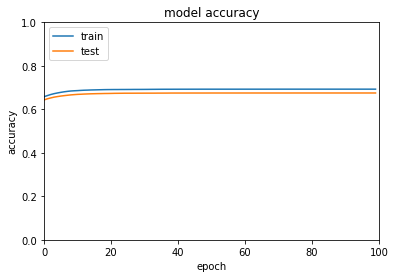

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.xlabel('epoch')
plt.xlim([0, NUM_EPOCHS])
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(weights_path+"/accuracy.png")
plt.show()

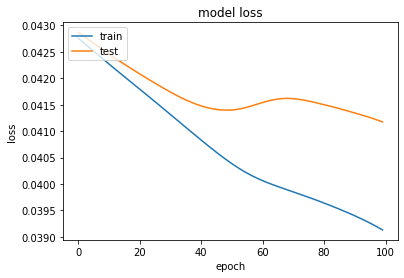

In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
#plt.ylim([0, 1])
plt.xlabel('epoch')
#plt.xlim([0, NUM_EPOCHS])
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(weights_path+"/loss.png")
plt.show()

In [ ]:
#confusion matrix
def plot_mat(cm):

  
  classes = [ "1 - Yes MS","0 - No MS"] # your y labels
  import seaborn as sns; sns.set_theme()
  sns.set(font_scale=2)
  plt.figure(figsize = (20,14))
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False,fmt=",")
  ax.set(title="Confusion Matrix", xlabel="Predicted Label", ylabel="True Label")
  plt.savefig(weights_path+"/ConfusionMatrix.png")

TN = hist.history['true_negatives'][-1]
FP = hist.history['false_positives'][-1]
FN = hist.history['false_negatives'][-1]
TP = hist.history['true_positives'][-1]
cm = [[TP,FP],[FN,TN]]
plot_mat(cm)

# Testing Model

In [ ]:
listTestImages,listTestMasks,listTestFilesImages,listTestFilesMasks,testCouples = upload_db_images(r'/content/drive/MyDrive/DB_final_project/DB-TEST',ModolalityType,couples)
imageArray = np.array(testCouples[73][0].dataobj)
maskArray = np.array(testCouples[73][1].dataobj)



In [ ]:
selecteImageArray = np.uint8(imageArray[:,:,245])
cv2_imshow(selecteImageArray)

In [ ]:
selecteMaskArray = maskArray[:,:,245]*255
cv2_imshow(selecteMaskArray)

In [ ]:
imageArray2, maskArray2 = crop_image(imageArray, maskArray)
imageArray3, maskArray3 = resize(imageArray, maskArray)

In [ ]:
def DevideImage(inputImage):
    imageParts = []
    
    for i in range(0, 256, crop_size):
        for j in range(0, 256, crop_size):
            newImage = np.array(inputImage[i:i+crop_size, j:j+crop_size])
            #newImage= (inputImage.crop(box))
            #newMask= (inputMask.crop(box))
            imageParts.append(newImage)

    return imageParts


devidedImageList = DevideImage(selecteImageArray)

In [ ]:
predictedCouple=DevideImage(np.uint8(imageArray3[:,:,246])/255)

In [ ]:
#test final 
unet_model.load_weights('/content/drive/MyDrive/New_Final_Project_Weights/Loss_functions/BinaryCrossentropy-Ep100-B32-CrSize32-CrPrecent0.2-LR1e-05-T2-Gamma3.0-Depth4/weights.091.hdf5')#path to hdf5 file

In [ ]:
def predictImage(listOfImages):
  listPrediction=[]
  for i in range(len(listOfImages)):
    pred = unet_model.predict(np.expand_dims(listOfImages[i],0))
    listPrediction.append(pred[0])
  return listPrediction

In [ ]:
predictedCouple= predictImage(predictedCouple)

In [ ]:
def CombineImage(listParts):# combine the parts together
  resImage=np.zeros((256,256))
  k=0
  for i in range(0, 256, crop_size):
      for j in range(0, 256, crop_size):
          resImage[i:i+crop_size, j:j+crop_size] = listParts[k][:,:,0]
          k=k+1
          
  return resImage

In [ ]:
combinedImage = CombineImage(predictedCouple)

In [ ]:
precentMask = (combinedImage > 0.5) * 1 #Filter Pixels with prediction lower then 50%

In [ ]:
cv2_imshow( precentMask*255)